In [3]:
library(purrr)
library(magrittr)
library(tidyr)
library(tidytext)
library(dplyr)
library(stringr)
library(ggplot2)
library(tm)
library(topicmodels)
library(broom)

library(e1071)
library(caret)
library(randomForest)

Warning message:
"package 'purrr' was built under R version 3.5.2"Warning message:
"package 'magrittr' was built under R version 3.5.2"
Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

Warning message:
"package 'tidyr' was built under R version 3.5.2"
Attaching package: 'tidyr'

The following object is masked from 'package:magrittr':

    extract

Warning message:
"package 'tidytext' was built under R version 3.5.2"Warning message:
"package 'dplyr' was built under R version 3.5.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'stringr' was built under R version 3.5.2"Warning message:
"package 'ggplot2' was built under R version 3.5.2"Warning message:
"package 'tm' was built under R version 3.5.2"Loading required package: NLP
Warning message:
"package 'NLP' was b

In [4]:
reg <- "([^A-Za-z\\d#@']+|'[^A-Za-z\\d#@]+)"

df <- read.csv(
  "..\\..\\data\\Weekly_data_top_week.csv",
  encoding = "UTF-8",
  stringsAsFactors = FALSE)

df_words <- read.csv(
  "..\\..\\data\\Weekly_data_tokenized.csv", 
  encoding = "UTF-8",
  stringsAsFactors = FALSE)

unique_df_words <- read.csv(
  "..\\..\\data\\Weekly_data_tokenized_unique.csv", 
  encoding = "UTF-8",
  stringsAsFactors = FALSE)

metrics <- read.csv(
  "..\\..\\data\\Song_Complexity.csv",
  encoding = "UTF-8",
  stringsAsFactors = FALSE
)

df <- merge(x = df, y = metrics, by = c("X"), all.x = TRUE)
colnames(df)[colnames(df) == "Songwriter.x"] <- "Songwriter"

#final_df <- merge(x = max_week, y = df, by = c("Artists", "Name", "Weeks.on.chart"), all.x = TRUE)

unique_df_words <- unique_df_words %>%
    mutate(Pop = ifelse(str_detect(Genre, regex("pop", ignore_case = TRUE)), TRUE, FALSE)) %>%
    filter(str_detect(Genre, regex("rap|pop", ignore_case = TRUE)))

df_words <- df_words %>%
    mutate(Pop = ifelse(str_detect(Genre, regex("pop", ignore_case = TRUE)), TRUE, FALSE)) %>%
    filter(str_detect(Genre, regex("rap|pop", ignore_case = TRUE)))

df <- df %>%
    mutate(Pop = ifelse(str_detect(Genre, regex("pop", ignore_case = TRUE)), TRUE, FALSE)) %>%
    filter(str_detect(Genre, regex("rap|pop", ignore_case = TRUE)))

Warning message:
"package 'bindrcpp' was built under R version 3.5.2"

## Prediction

In [317]:
set.seed(0)
num_songs_present <- 2
num_words_to_filter <- 5

# one entry for each song-word
each_song <- unique_df_words %>%
    count(word, ID, Artists, Pop)

num_songs <- table(each_song$word)

good_words <- names(num_songs[num_songs >= num_songs_present])

word_count_matrix <- df_words %>%
  count(ID, word, sort = TRUE) %>%
  filter(word %in% good_words, n >= num_words_to_filter) %>%
  ungroup() %>% # do we need this?
  cast_dtm(ID, word, n)

indices <- sample(word_count_matrix$dimnames$Docs)

dtm.train <- word_count_matrix[indices[1:(nrow(word_count_matrix)*0.8)],]
dtm.test <- word_count_matrix[indices[(nrow(word_count_matrix)*0.8+1):nrow(word_count_matrix)],]

df.train <- df[df$ID %in% indices[1:(nrow(word_count_matrix)*0.8)], ]
df.test <- df[df$ID %in% indices[(nrow(word_count_matrix)*0.8+1):nrow(word_count_matrix)], ]
df.train.lab <- as.factor(df.train$Pop)
df.test.lab <- as.factor(df.test$Pop)

convert_count <- function(x) {
  y <- ifelse(x > 0, 1, 0)
  y <- factor(y, levels=c(0, 1), labels=c("No", "Yes"))
  y
}

trainNB <- apply(dtm.train, MARGIN = 2, convert_count)
testNB <- apply(dtm.test, MARGIN = 2, convert_count)

In [318]:
classifier <- naiveBayes(trainNB, df.train.lab, laplace = 0.3)
pred <- predict(classifier, testNB, type = "class")
conf.mat <- confusionMatrix(pred, df.test.lab)

conf.mat

Confusion Matrix and Statistics

          Reference
Prediction Pop Rap
       Pop 251 185
       Rap  93  50
                                          
               Accuracy : 0.5199          
                 95% CI : (0.4783, 0.5612)
    No Information Rate : 0.5941          
    P-Value [Acc > NIR] : 0.9999          
                                          
                  Kappa : -0.0614         
 Mcnemar's Test P-Value : 4.82e-08        
                                          
            Sensitivity : 0.7297          
            Specificity : 0.2128          
         Pos Pred Value : 0.5757          
         Neg Pred Value : 0.3497          
             Prevalence : 0.5941          
         Detection Rate : 0.4335          
   Detection Prevalence : 0.7530          
      Balanced Accuracy : 0.4712          
                                          
       'Positive' Class : Pop             
                                          

## SVM

In [5]:
set.seed(0)
num_songs_present <- 10
num_words_to_filter <- 20

# one entry for each song-word
each_song <- unique_df_words %>%
    count(word, ID, Artists, Pop)

num_songs <- table(each_song$word)

good_words <- names(num_songs[num_songs >= num_songs_present])

word_count_matrix <- df_words %>%
  count(ID, word, sort = TRUE) %>%
  filter(word %in% good_words, n >= num_words_to_filter) %>%
  ungroup() %>% # do we need this?
  cast_dtm(ID, word, n)

indices <- sample(word_count_matrix$dimnames$Docs)

dtm.train <- word_count_matrix[indices[1:(nrow(word_count_matrix)*0.8)],]
dtm.test <- word_count_matrix[indices[(nrow(word_count_matrix)*0.8+1):nrow(word_count_matrix)],]

df.train <- df[df$ID %in% indices[1:(nrow(word_count_matrix)*0.8)], ]
df.test <- df[df$ID %in% indices[(nrow(word_count_matrix)*0.8+1):nrow(word_count_matrix)], ]
df.train.lab <- as.factor(df.train$Pop)
df.test.lab <- as.factor(df.test$Pop)

convert_count <- function(x) {
  y <- ifelse(x > 0, 1, 0)
  y
}

trainSVM <- apply(dtm.train, MARGIN = 2, convert_count)
testSVM <- apply(dtm.test, MARGIN = 2, convert_count)

In [42]:
trainSVM <- trainSVM[, colSums(trainSVM != 0) > 0]
model <- svm(x = trainSVM, 
             y = df.train.lab,
             kernel = "radial",
             cost = 1,
             gamma = 12321
            )

In [49]:
pred <- predict(model, testSVM[, colnames(trainSVM)])
conf.mat <- confusionMatrix(pred, df.test.lab)

In [50]:
conf.mat

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE     5   16
     TRUE     95  100
                                          
               Accuracy : 0.4861          
                 95% CI : (0.4177, 0.5549)
    No Information Rate : 0.537           
    P-Value [Acc > NIR] : 0.9415          
                                          
                  Kappa : -0.093          
 Mcnemar's Test P-Value : 1.327e-13       
                                          
            Sensitivity : 0.05000         
            Specificity : 0.86207         
         Pos Pred Value : 0.23810         
         Neg Pred Value : 0.51282         
             Prevalence : 0.46296         
         Detection Rate : 0.02315         
   Detection Prevalence : 0.09722         
      Balanced Accuracy : 0.45603         
                                          
       'Positive' Class : FALSE           
                                          

In [1]:
#trainSVM <- trainSVM[, colSums(trainSVM != 0) > 0]
#bestsvm <- tune.svm(x = trainSVM, 
#         y = df.train.lab,
#         degree = c(1,2,3,4,5),
#         gamma = seq(0.1, 2, 0.2),
#         cost = seq(1, 40, 4),
#         nu = seq(0, 1, 0.2))

In [454]:
conf.mat

Confusion Matrix and Statistics

          Reference
Prediction Pop Rap
       Pop  95  87
       Rap  12  14
                                          
               Accuracy : 0.524           
                 95% CI : (0.4538, 0.5935)
    No Information Rate : 0.5144          
    P-Value [Acc > NIR] : 0.4179          
                                          
                  Kappa : 0.027           
 Mcnemar's Test P-Value : 1.028e-13       
                                          
            Sensitivity : 0.8879          
            Specificity : 0.1386          
         Pos Pred Value : 0.5220          
         Neg Pred Value : 0.5385          
             Prevalence : 0.5144          
         Detection Rate : 0.4567          
   Detection Prevalence : 0.8750          
      Balanced Accuracy : 0.5132          
                                          
       'Positive' Class : Pop             
                                          

Just like in the Robotic vs. Non-robotic case, presence and absence of words do not seem to even be a good predictor of Genre. 

## Differences in sentiment

In [25]:
num_words_to_filter = 5

nrc <- sentiments %>%
    filter(lexicon == "nrc") %>%
    dplyr::select(word, sentiment)

sources <- unique_df_words %>%
    group_by(Pop) %>%
    mutate(total_words = n()) %>%
    ungroup() %>%
    distinct(Name, Pop, total_words)

by_source_sentiment <- unique_df_words %>%
    inner_join(nrc, by = "word") %>%
    count(sentiment, Name) %>%
    ungroup() %>%
    complete(sentiment, Name, fill = list(n = 0)) %>%
    inner_join(sources, "Name") %>%
    group_by(Pop, sentiment, total_words) %>%
    summarize(words = sum(n)) %>%
    ungroup()

sentiment_diff <- by_source_sentiment %>%
    group_by(sentiment) %>%
    do(tidy(poisson.test(.$words, .$total_words))) %>%
    ungroup() %>%
    mutate(sentiment = reorder(sentiment, estimate))

# plot
sentplot <- sentiment_diff  %>%
    ggplot(aes(sentiment, estimate)) + 
    geom_errorbar(width = .5, aes(ymin = conf.low, ymax = conf.high)) +
    geom_point(shape = 21, size = 2.5, fill = "white") +
    scale_y_continuous("% change",
                       limits = c(0.6, 1.2),
                       breaks = c(0.6, 0.8, 1, 1.2, 1.4, 1.6),
                       labels = c("-40%", "-20%", "0%", "20%", "40%", "60%")) +
    coord_flip() + 
    theme_bw() +
    ggtitle("Percent Change in Mean Sentiment from Pop to Rap") + 
    theme(plot.title = element_text(hjust = -0.00, vjust = 3, size = 17))

ggsave("..//..//visualizations//rapvspopsentimentdiff.png",
       plot = sentplot,
       dpi = 800, width = 7 * 1.2, height = 5 * 1.2)

#ggsave(filename, plot = last_plot(), device = NULL, path = NULL,
#  scale = 1, width = NA, height = NA, units = c("in", "cm", "mm"),
#  dpi = 300, limitsize = TRUE, ...)

In [27]:
1 - 0.6745692

[1] 0.3254308

In [26]:
sentiment_diff

sentiment,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
anger,1.1129736,9078,1.196339e-10,8688.879,1.0770778,1.1501295,Comparison of Poisson rates,two.sided
anticipation,0.7954373,7302,1.731662e-41,8094.985,0.7693991,0.8223663,Comparison of Poisson rates,two.sided
disgust,1.0763692,5958,3.020513e-04,5779.491,1.0340640,1.1204912,Comparison of Poisson rates,two.sided
fear,0.9369574,8173,1.018802e-04,8405.219,0.9066582,0.9683013,Comparison of Poisson rates,two.sided
joy,0.6745692,7155,2.937968e-127,8612.620,0.6531482,0.6966855,Comparison of Poisson rates,two.sided
negative,0.9362668,15714,4.789848e-08,16165.705,0.9143589,0.9587161,Comparison of Poisson rates,two.sided
positive,0.7803702,15111,3.347550e-99,16906.918,0.7626320,0.7985243,Comparison of Poisson rates,two.sided
sadness,0.7975338,6947,1.252555e-38,7691.738,0.7707587,0.8252495,Comparison of Poisson rates,two.sided
surprise,0.8033287,4273,6.966938e-23,4714.757,0.7689986,0.8392103,Comparison of Poisson rates,two.sided
trust,0.8215573,9330,1.465112e-38,10185.746,0.7975322,0.8463171,Comparison of Poisson rates,two.sided


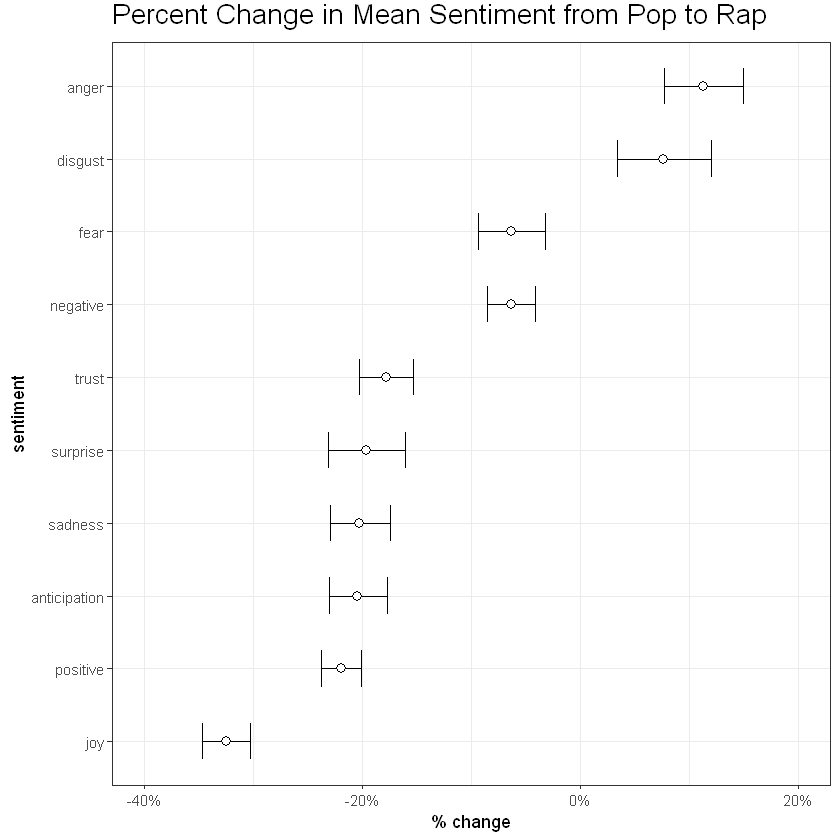

In [31]:
sentplot

Rap uses less words relating to joy, positivity, anticipation, sadness, surprise and trust than Pop music. On the other hand, Rap music uses more words relating to disgust and anger than pop music. Each result is significantly different than 0%.

## Differences in metrics - defined + metadata

In [105]:
set.seed(1)
df$Pop <- factor(df$Pop)
df$Songwriter <- factor(df$Songwriter)

indices <- sample(df$X)
train <- df[df$X %in% indices[1:(nrow(df)*0.8)],]
test <- df[df$X %in% indices[(nrow(df)*0.8+1):nrow(df)],]

train.lab = df[df$X %in% indices[1:(nrow(df)*0.8)],]$Pop
test.lab = df[df$X %in% indices[(nrow(df)*0.8+1):nrow(df)],]$Pop

In [106]:
first <- glm(Pop ~ 1,
             data = train,
             family = "binomial")
last <- glm(Pop ~ Peak.position + Weeks.on.chart + diversity + 
                  profanity_ratio + tf_idf_complexity + Songwriter +
                  mean_word_rarity + mean_word_length,
             data = train,
             family = "binomial")
#summary(last)

In [107]:
#summary(last)

In [108]:
selected <- step(last, 
                 #scope = list(lower = first, upper = last), 
                 directions = "backwards", 
                 k = log(2983))

Start:  AIC=3132.21
Pop ~ Peak.position + Weeks.on.chart + diversity + profanity_ratio + 
    tf_idf_complexity + Songwriter + mean_word_rarity + mean_word_length

                    Df Deviance    AIC
- mean_word_length   1   3060.2 3124.2
- diversity          1   3060.5 3124.5
- tf_idf_complexity  1   3060.7 3124.7
- mean_word_rarity   1   3060.8 3124.8
- Weeks.on.chart     1   3061.6 3125.6
- profanity_ratio    1   3061.7 3125.7
<none>                   3060.2 3132.2
- Peak.position      1   3069.9 3133.9
- Songwriter         1   3100.7 3164.7

Step:  AIC=3124.23
Pop ~ Peak.position + Weeks.on.chart + diversity + profanity_ratio + 
    tf_idf_complexity + Songwriter + mean_word_rarity

                    Df Deviance    AIC
- diversity          1   3060.5 3116.5
- tf_idf_complexity  1   3060.7 3116.7
- mean_word_rarity   1   3060.9 3116.9
- Weeks.on.chart     1   3061.6 3117.6
- profanity_ratio    1   3061.8 3117.8
<none>                   3060.2 3124.2
- Peak.position      1   306

In [111]:
tmp <- glm(Pop ~ Peak.position + Songwriter,
   data = test,
   family = "binomial")
summary(tmp)


Call:
glm(formula = Pop ~ Peak.position + Songwriter, family = "binomial", 
    data = test)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7892  -1.2534   0.8447   1.0734   1.2090  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     0.586350   0.168285   3.484 0.000493 ***
Peak.position  -0.006603   0.002816  -2.345 0.019031 *  
SongwriterTrue  0.828483   0.294507   2.813 0.004906 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 807.99  on 595  degrees of freedom
Residual deviance: 791.25  on 593  degrees of freedom
AIC: 797.25

Number of Fisher Scoring iterations: 4


In [110]:
pred <- predict(tmp, test, type = "response")
#conf.mat <- confusionMatrix(pred, test.lab)

#conf.mat

In [83]:
confusionMatrix(factor(round(pred)), factor(as.numeric(test$Pop) - 1))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  23  39
         1 204 330
                                         
               Accuracy : 0.5923         
                 95% CI : (0.5516, 0.632)
    No Information Rate : 0.6191         
    P-Value [Acc > NIR] : 0.9176         
                                         
                  Kappa : -0.0051        
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.10132        
            Specificity : 0.89431        
         Pos Pred Value : 0.37097        
         Neg Pred Value : 0.61798        
             Prevalence : 0.38087        
         Detection Rate : 0.03859        
   Detection Prevalence : 0.10403        
      Balanced Accuracy : 0.49782        
                                         
       'Positive' Class : 0              
                                         

Findings:
- The lower your peak position, the more likely you are to be a rap song
- Pop songs are more likely than rap songs to include songwriters.

In [88]:
table(df$Pop, df$Songwriter)

       
        False True
  FALSE  1066   75
  TRUE   1539  303

Rows are Pop or not, columns are songwriter or not.

We can see that 19.688% of Pop songs included a songwriter but only 7.0356% of rap songs included a songwriter.

In [269]:
df[df$Pop == TRUE, ]$Pop <- "Pop"
df[df$Pop == FALSE, ]$Pop <- "Rap"

In [270]:
peakplot <- ggplot(data = df, aes(x = Peak.position)) +
    geom_histogram(aes(fill=Pop), bins = 100, position = "identity", alpha = 0.4) +
    scale_fill_manual("Genre", values = c("steelblue1", "goldenrod")) +
    ggtitle("Distribution of Peak Song Positions") + 
    ylab("Number of songs") +
    xlab("Peak position") + 
    theme_bw() +
    theme(legend.justification = c(1, 1), 
          legend.position = c(0.99, 0.99),
    plot.title = element_text(hjust = -0.0, vjust = 3, size = 17))

ggsave("..//..//visualizations//peakposition.png",
       plot = peakplot,
       dpi = 800, width = 7 * 1.2, height = 5 * 1.2)

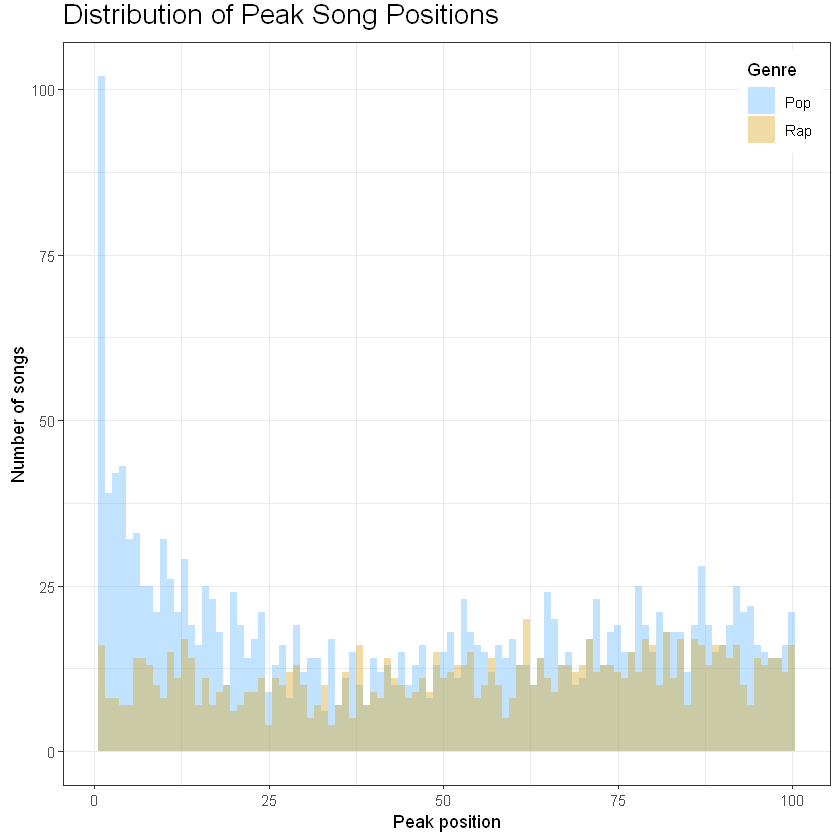

In [271]:
peakplot

## Peak song positions across time

In [309]:
acrosstime <- df %>% 
    mutate(ym = as.numeric(format(as.Date(Week, format = "%Y-%m-%d"), "%Y%m"))) %>%
    group_by(ym, Pop) %>%
    summarise(average.peak.position = mean(Peak.position))

acrosstime$idx = rep(1:116, each = 2)

acrosstimeplot <- acrosstime %>%
    ggplot() +
    geom_line(aes(x = idx, y = average.peak.position, colour = Pop), alpha = 0.5) +
    scale_colour_manual("Genre", values = c("steelblue1", "goldenrod")) +
    scale_y_reverse() +
    scale_x_continuous("Year",
                       breaks = c(0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120),
                       labels = c("2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019")) + 
    ylab("Average peak position") +
    theme_bw() +
    ggtitle("Average Peak Position in Each Genre") +
    theme(legend.justification = c(1, 1), 
          legend.position = c(0.08, 0.19),
    plot.title = element_text(hjust = -0.0, vjust = 3, size = 17))

ggsave("..//..//visualizations//peakpositionacrosstime.png",
       plot = acrosstimeplot,
       dpi = 800, width = 12 * 1.2, height = 5 * 1.2)

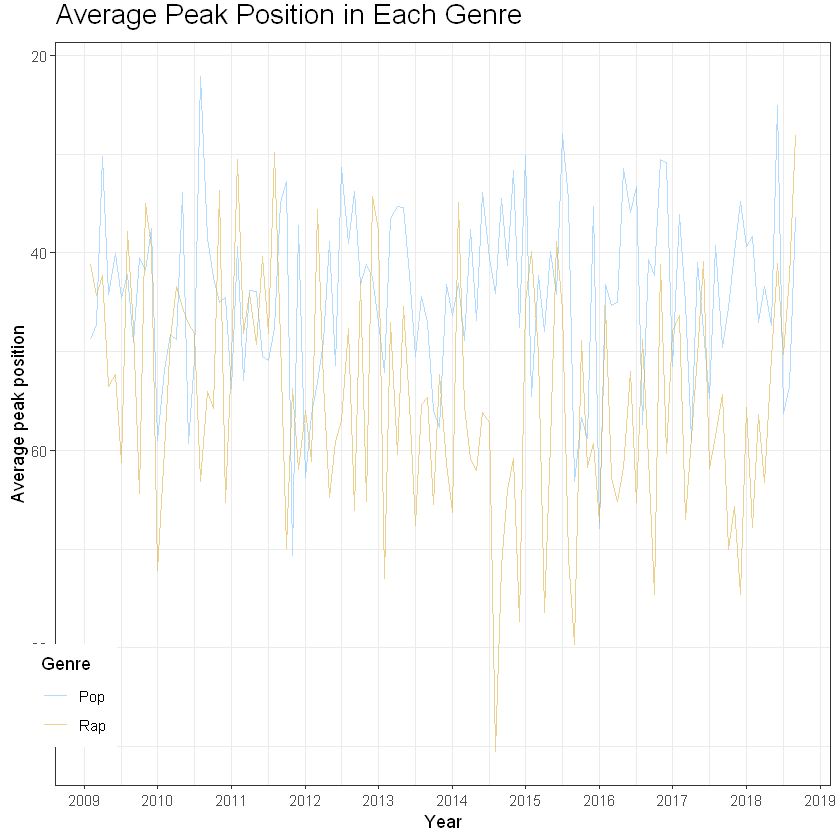

In [310]:
acrosstimeplot

This chart shows that pop songs tend to have a higher peak position than rap songs do.

## Bonus: LDA

In [20]:
word_counts <- df_words %>%
    count(Name, word, sort = TRUE) %>%
    filter(n > 1) %>%
    ungroup() # do we need this?
    
word_count_matrix <- word_counts %>% cast_dtm(Name, word, n)

# create LDA object
songs_lda <- LDA(word_count_matrix, k = 2, control = list(seed = 1))
topics <- tidy(songs_lda, matrix = "beta")
    
# visualize
top_terms <- topics %>%
    group_by(topic) %>%
    top_n(30, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)

In [21]:
top_terms[top_terms$topic == 1, ]$topic <- "Topic 1"
top_terms[top_terms$topic == 2, ]$topic <- "Topic 2"
#top_terms[top_terms$topic == 3, ]$topic <- "Topic 3"
#top_terms[top_terms$topic == 4, ]$topic <- "Topic 4"

In [22]:
ldaplot <- top_terms %>%
    ggplot() +
    geom_col(aes(reorder(term, beta), beta, fill = topic), 
             width = 0.5, show.legend = FALSE, alpha = 0.8) +
    facet_wrap(. ~ topic, scales = "free_y") + # partition by topic
    coord_flip() +
    ylab("Probability") +
    xlab("") +
    theme_bw() + 
    scale_fill_manual("", values = c("steelblue1", "goldenrod")) +
    ggtitle("Word Probabilities for Each Topic") + 
    theme(plot.title = element_text(hjust = -0.0, vjust = 3, size = 17))

ggsave("..//..//visualizations//ldaplot.png",
       plot = ldaplot,
       dpi = 800, width = 5 * 1.2, height = 7 * 1.2)

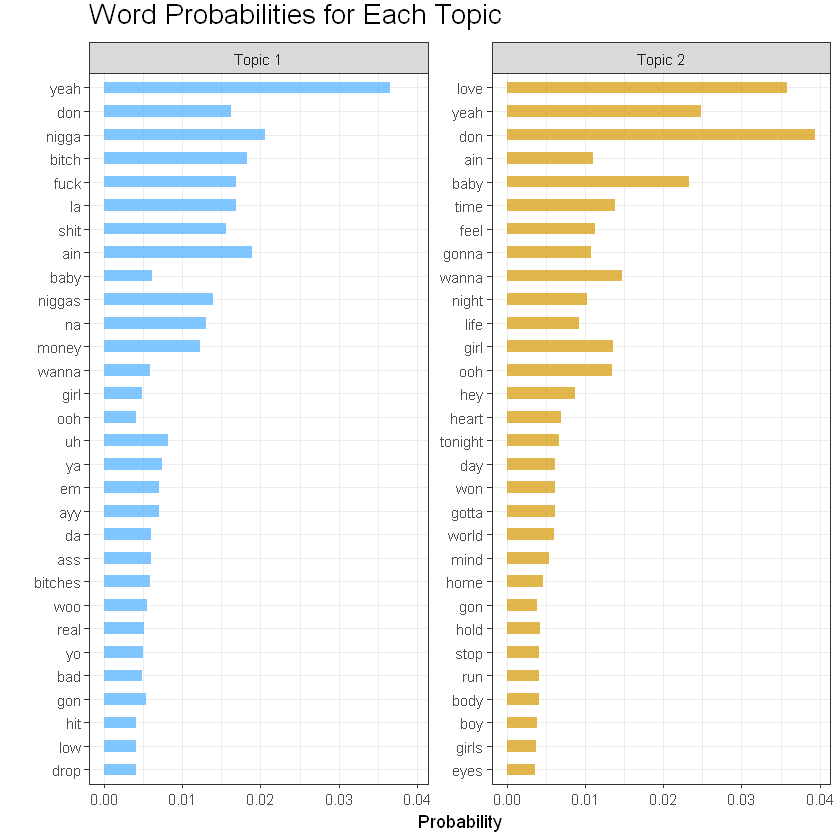

In [23]:
ldaplot

Key takeaways:

- Words most likely to be generated from topic 1 include love, yeah, baby, wanna, la, and ooh. These seem to originate from pop songs.
- In contrast, words most likely to be generated from topic 2 include many expletives, particularly ones in rap songs. 

This leads us to believe LDA accurately captures a difference between the language used in pop songs and rap songs.
